In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(10)

data = pd.read_csv('HWs/HW5/Files/homework-5/data/Pokemon.csv')
data.columns = [d.strip().lower().replace(' ', '_').replace('.','') for d in data.columns.to_list()]

# Exercise 1

The column names were changed: spaces were replaced with underscores, first letters were converted to lower case, and other small things to make the columns match with the general naming conventions.

# Exercise 2

In [2]:
data.type_1.unique()

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

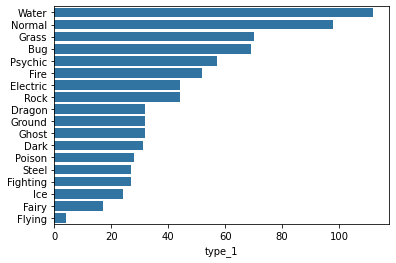

In [3]:
sns.barplot(data.type_1.value_counts(), errorbar=None, orient='h')
plt.show()

I count 18 types of pokemon. There are definitely some with very few values, with the 12 lowest all below about 40.

In [4]:
value_counts = data.type_1.value_counts()
least_common = value_counts.nsmallest(12).index
data['type_1'] = data['type_1'].replace(least_common, 'Other')
data.type_1.value_counts()

Other      342
Water      112
Normal      98
Grass       70
Bug         69
Psychic     57
Fire        52
Name: type_1, dtype: int64

In [5]:
from sklearn.preprocessing import LabelEncoder

le_t1 = LabelEncoder()
le_t1 = le_t1.fit(data['type_1'])
le_t1_transform = le_t1.transform(data['type_1'])
data['type_1'] = le_t1_transform

le_leg = LabelEncoder()
le_leg = le_leg.fit(data['legendary'])
le_leg_transform = le_leg.transform(data['legendary'])
data['legendary'] = le_leg_transform

# Exercise 3

In [6]:
from sklearn.model_selection import train_test_split

X = data.drop('type_1', axis=1)
Y = data.type_1

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=.3, stratify=Y)

x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

train_len_check = (len(x_train) == len(y_train)) & (len(x_train) == len(data) * .7)
test_len_check = (len(x_test) == len(y_test)) & (len(x_test) == len(data) * .3)

print(f'Training Dataset Length Check: {train_len_check}')
print(f'Testing Dataset Length Check: {test_len_check}')

Training Dataset Length Check: True
Testing Dataset Length Check: True


In [7]:
from sklearn.model_selection import StratifiedKFold


# Perform 5-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True)

indicies = []
for _, (train_index, test_index) in enumerate(skf.split(x_train,y_train)):
    indicies.append(
        (train_index, test_index)
    )

Stratified sampling for cross validation will be useful here since we have so many different levels for the outcome level (7). Without this step, we would likely see class imbalances between the different folds, affecting our results.

# Exercise 4

#### **I choose not to include the target variable here since the factor levels do not represent an ordering, and thus correlation of features with the numeric output are not important.**

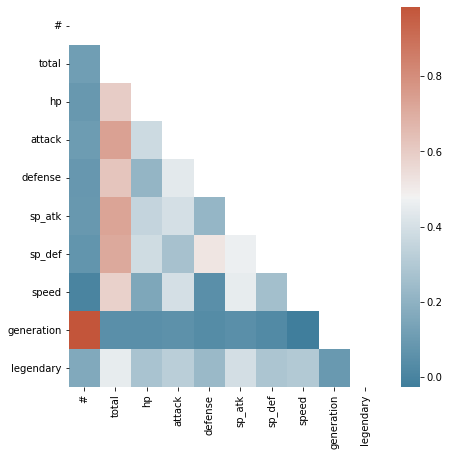

In [8]:
corr_df = x_train.select_dtypes(np.number).corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr_df, dtype=bool))

plt.figure(figsize=(7,7))

sns.heatmap(corr_df,
            mask=mask,
            cmap=cmap
            )
plt.show()

We can see that total has moderate/high correlation with many of the stats, which makes sense, since total represents the sum of all relevant stats. Also, the perfect corrleation # and generation can likely be explained by the fact that smaller numbers were an earlier generation and larger numbers are more recent.  
  
Outside of these obvious ones, we see that defense and sp_def are correlated, as is attack and some of the other attack stats.

# Exercise 5

In [9]:
# Choose features

features = ['legendary', 'generation', 'sp_atk', 'attack',
            'speed', 'defense', 'hp', 'sp_def']

x_train, x_test = (x_train[features], x_test[features])

# Dummy encode two features
x_train = pd.get_dummies(x_train, columns=['legendary', 'generation'], dtype=int)
x_test = pd.get_dummies(x_test, columns=['legendary', 'generation'], dtype=int)

In [10]:
from sklearn.preprocessing import StandardScaler

# Center and scale all predictors
ss = StandardScaler()
x_train = pd.DataFrame(ss.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(ss.fit_transform(x_test), columns=x_test.columns)

# Exercise 6

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

params_en = {'C': np.arange(.01,3.02,1/3),
             'l1_ratio': np.arange(0,1.01,1/9)}

en = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=5000,tol=1e-3)
en_grid = GridSearchCV(
    estimator=en,
    param_grid=params_en,
    scoring='roc_auc_ovr',
    cv=indicies,
    verbose=1).fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [12]:
en_grid.best_params_

{'C': 0.6766666666666666, 'l1_ratio': 0.7777777777777777}

# Exercise 7

In [13]:
from sklearn.ensemble import RandomForestClassifier

params_rf = {'n_estimators': np.arange(10,116,15),
             'min_samples_split': np.arange(2,18,2),
             'max_features': [1,2,3,4,6,8,11,14]}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=params_rf,
    cv=indicies,
    scoring='roc_auc_ovr',
    verbose=1,
    n_jobs=-1).fit(x_train,y_train)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


In [14]:
rf_grid.best_params_

{'max_features': 6, 'min_samples_split': 10, 'n_estimators': 115}

**n_estimators:** This represents how many trees are in the forest. Each tree is grown by taking a random sample of features and a random sample of the data to fit a descision tree on. In the end, the majority vote from all trees is taken as the output. More trees can result in better performance, but eventually diminishing returns are achieved.  
  
**min_samples_split:** This represents how many samples are required for an internal node to be further split. Larger values can prevent overfitting by not letting the tree find patterns that apply to a small subset of the data.  
  
**max_features:** This represents how many features each tree has access to while training. A smaller value allows trees to grow independently and mostly uncorrelated from each other since the trees have access to different features.  
  
max_features (or mtry in R) cannot be less than one since then the trees would have no features to train on, or greater than 14 since that is how many features we have in total.

# Exercise 8

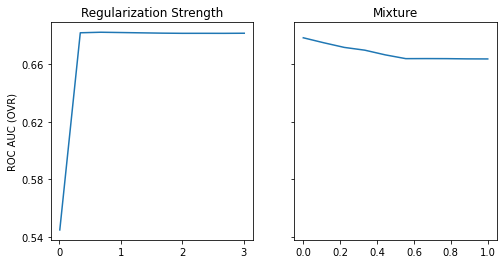

In [15]:
en_results_df = pd.DataFrame(en_grid.cv_results_)

en_results_c, en_results_l1 = ([], [])

for c in params_en['C']:
    en_results_c.append(
        en_results_df[en_results_df['param_C'] == c]['mean_test_score'].mean()
    )
for l in params_en['l1_ratio']:
    en_results_l1.append(
        en_results_df[en_results_df['param_l1_ratio'] == l]['mean_test_score'].mean()
    )

fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].plot(params_en['C'], en_results_c)
ax[0].set_title('Regularization Strength')
ax[0].set_ylabel('ROC AUC (OVR)')
ax[0].set_yticks(np.arange(.54,.69,.04))

ax[1].plot(params_en['l1_ratio'], en_results_l1)
ax[1].set_title('Mixture', fontsize=12)
plt.show()

We notice that moderate regularization strength improves performance, and a higher l1_ratio (closer to lasso) perform better, **ALL ELSE CONSTANT**.

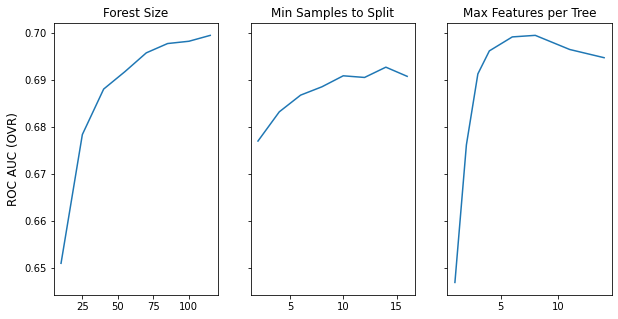

In [16]:
rf_results_df = pd.DataFrame(rf_grid.cv_results_)

rf_results_trees, rf_results_mss, rf_results_max_feat = ([], [], [])

for n in params_rf['n_estimators']:
    rf_results_trees.append(
        rf_results_df[rf_results_df['param_n_estimators'] == n]['mean_test_score'].mean()
    )
for m in params_rf['min_samples_split']:
    rf_results_mss.append(
        rf_results_df[rf_results_df['param_min_samples_split'] == m]['mean_test_score'].mean()
    )
for f in params_rf['max_features']:
    rf_results_max_feat.append(
        rf_results_df[rf_results_df['param_max_features'] == f]['mean_test_score'].mean()
    )

fig, ax = plt.subplots(1,3, sharey=True, figsize=(10,5))
ax[0].plot(params_rf['n_estimators'], rf_results_trees)
ax[0].set_title('Forest Size')
ax[0].set_ylabel('ROC AUC (OVR)', fontsize=12)

ax[1].plot(params_rf['min_samples_split'], rf_results_mss)
ax[1].set_title('Min Samples to Split')

ax[2].plot(params_rf['max_features'], rf_results_max_feat)
ax[2].set_title('Max Features per Tree')
plt.show()

We notice that more trees, more samples required to split an internal node, and more features available to each tree performed best, **ALL ELSE CONSTANT**.

In [17]:
print(f"The best model for Elastic Net: {en_grid.best_params_}")
print(f"The best model for Random Forests: {rf_grid.best_params_}")

The best model for Elastic Net: {'C': 0.6766666666666666, 'l1_ratio': 0.7777777777777777}
The best model for Random Forests: {'max_features': 6, 'min_samples_split': 10, 'n_estimators': 115}


# Exercise 9

### Evaluation of RF Model on Test Set

In [18]:
from sklearn.metrics import roc_auc_score

rf_best = RandomForestClassifier(n_estimators=85, min_samples_split=12, 
                                 max_features=4).fit(x_train,y_train)

rf_pred = rf_best.predict_proba(x_test)
test_performance_rf = roc_auc_score(y_test.tolist(),rf_pred, multi_class='ovr')
print(f'RF Model Test ROC AUC: {round(test_performance_rf,3)}')

RF Model Test ROC AUC: 0.729


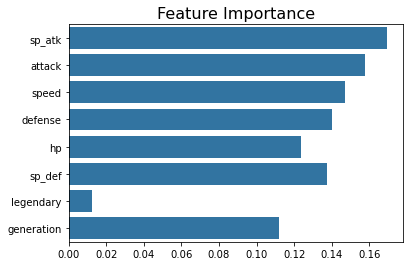

In [19]:
feat_imp = pd.DataFrame(rf_best.feature_importances_, index=x_train.columns.values)
feat_imp.loc['legendary'] = feat_imp.loc['legendary_0'] + feat_imp.loc['legendary_1']

gen_sum = 0
for j in range(1,7):
    gen_sum += feat_imp.loc[f'generation_{j}']
feat_imp.loc['generation'] = gen_sum

feat_imp.drop(['legendary_0', 'legendary_1', 'generation_1', 'generation_2',
               'generation_3', 'generation_4', 'generation_5',
               'generation_6'], axis=0, inplace=True)

sns.barplot(feat_imp[0], orient='h')
plt.xlabel('')
plt.title('Feature Importance', fontsize=16)
plt.show()

We notice that the features were all equally importance except for legendary. This could happen because there are an equal number of legendaries for each type, making it a not useful predictor of pokemon type.

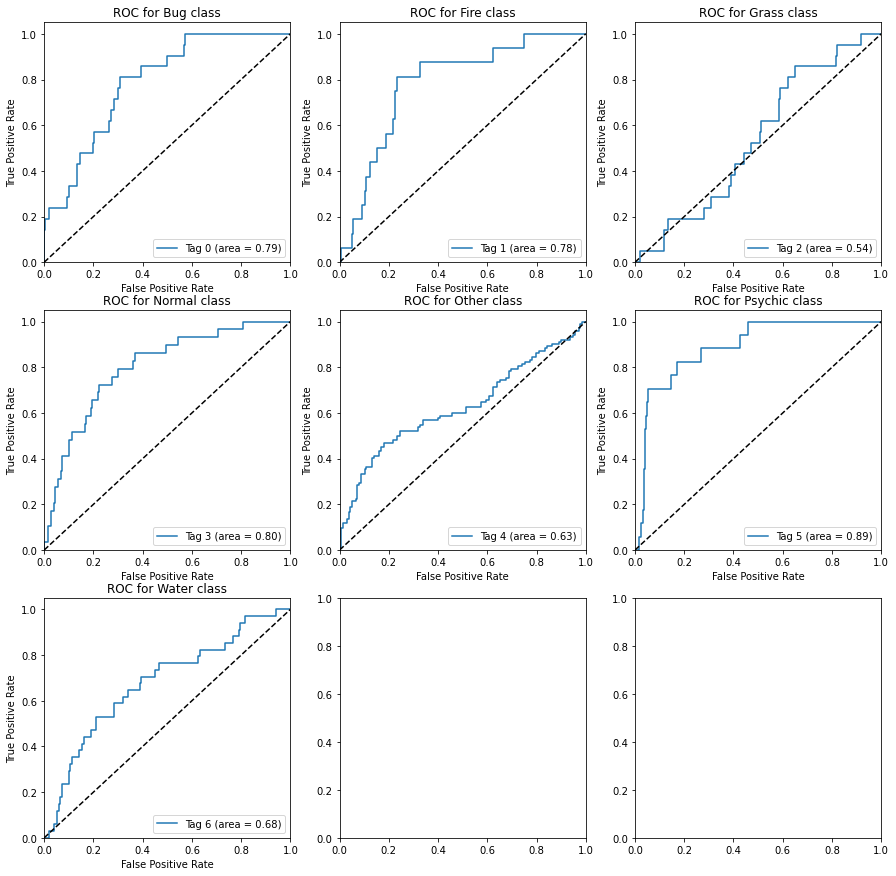

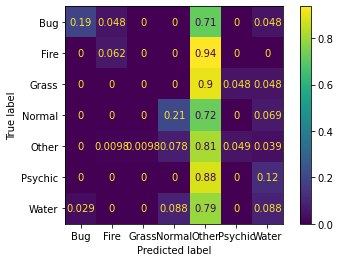

In [20]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
ivt = le_t1.inverse_transform([0,1,2,3,4,5,6])
n_classes = rf_pred.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, rf_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
ax = axes.ravel() # Flatten the 3x3 matrix into an array for easy indexing

for i in range(n_classes):
    ax[i].plot(fpr[i], tpr[i], label=f'Tag {i} (area = {roc_auc[i]:.2f})')
    ax[i].plot([0, 1], [0, 1], 'k--')
    ax[i].set_xlim([0.0, 1.0])
    ax[i].set_ylim([0.0, 1.05])
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')
    ax[i].set_title(f'ROC for {ivt[i]} class')
    ax[i].legend(loc="lower right")
    
plt.show()

fig.tight_layout()

# Confusion matrix
inverse_transform = {i: val for i, val in enumerate(le_t1.inverse_transform(range(7)))}
y_test_transform = [inverse_transform[num] for num in y_test]
y_tred_transform = [inverse_transform[num] for num in rf_best.predict(x_test)]
cm = confusion_matrix(y_test_transform, y_tred_transform, normalize='true')
cm_display = ConfusionMatrixDisplay(cm, display_labels=[j for j in inverse_transform.values()]).plot()
plt.show()

The model did well for predicting "Other", with an 86% success rate. We can see that the model did poorly for predicting classes besides "Other"; in fact, it predicted "Other" for almost every test point. This could be for a few reasons. First, there is a significant class imbalance in the data. As shown below, there are far more in the "Other" category than the rest. Even though we stratified for the train/test split and for the CV Splitting, the model is mostly seeing "Other" as the correct outcome. Hence, it makes sense that with seven possible outcomes, the outcome with the highest predicted probability is the one with the most data points. 

The least accurate was for the "Grass" class, which we can see by looking at the ROC AUC curves. At certain threshholds, the model actually did worse than chance at predicting these outcomes.

In [21]:
data['type_1'].value_counts()

4    342
6    112
3     98
2     70
0     69
5     57
1     52
Name: type_1, dtype: int64

# Exercise 11

### Boostrap resampling of Steph Curry's 2020-2021 3 point attemps

In [22]:
data2 = np.concatenate((np.ones(337), np.zeros(464)))

In [27]:
from sklearn.utils import resample

emperical_means = []
for _ in range(1000):
    emperical_means.append(
        np.mean(resample(data2))
    )

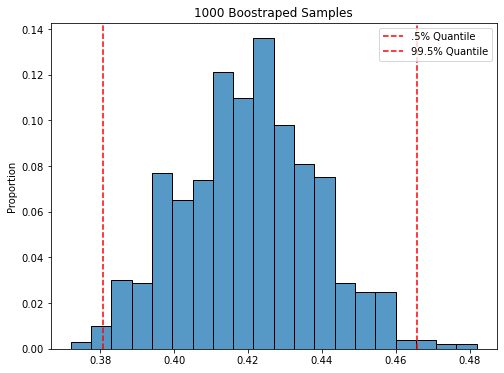

In [47]:
plt.figure(figsize=(8,6))
sns.histplot(emperical_means, bins=20, stat='proportion')
plt.title('1000 Boostraped Samples')
plt.axvline(np.quantile(emperical_means,.005), ls='--', c='r', label='.5% Quantile')
plt.axvline(np.quantile(emperical_means,.995), ls='--', c='r', label='99.5% Quantile')
plt.legend()
plt.show()

In [43]:
print(f"99% Confidence Interval (Quantiles): {round(np.quantile(emperical_means,.005),3)} - {round(np.quantile(emperical_means,.995),3)}")

99% Confidence Interval (Quantiles): 0.381 - 0.466
